In [1]:
import numpy as np
import pandas as pd
import torch
_ = torch.manual_seed(10)
import os
import math
from sbi import utils as utils
import sbi
from sbi import inference
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
import scipy.io as sio

In [2]:
initial_data = sio.loadmat("pancreatic1.mat")
init_obs = sio.loadmat("CancerDatasets.mat")

In [3]:
theta = torch.from_numpy(initial_data["part_vals_prior"]).to(torch.float32)
x = torch.from_numpy(initial_data["prior_pred_sim"]).to(torch.float32)
x_0 = torch.from_numpy(init_obs['Pancreatic_data'][:,0][0:19]).to(torch.float32)

In [4]:
lower = torch.ones(9)
lower[0],lower[1],lower[5],lower[6] = 0*lower[0], 0*lower[1],0*lower[5], 0*lower[6]
lower[4] = 2 * lower[4]
upper = torch.ones(9)
upper[2],upper[3],upper[7],upper[8] = 50*upper[2],24*19*upper[3],50*upper[7],24*32*upper[8]
upper[4] = 19 * upper[4]

In [5]:
priorDist = utils.BoxUniform(lower,upper)
def simulator(theta):
    return theta
_,prior = prepare_for_sbi(simulator,priorDist)

In [6]:
inference = sbi.inference.SNLE(prior=prior, density_estimator='nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 145 epochs.

In [7]:
posterior_samples = posterior.sample((1000,),x = x_0)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

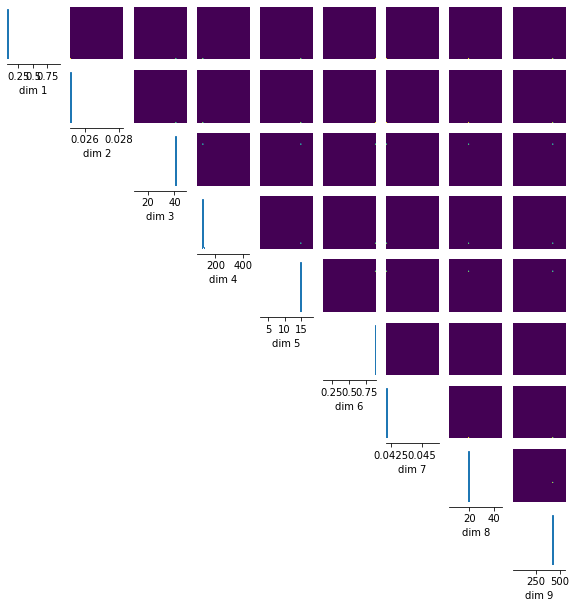

In [8]:
from sbi import analysis as analysis
_ = analysis.pairplot(
    posterior_samples, figsize=(10, 10)
)

In [9]:
mdic = {"theta_new": posterior_samples.numpy(), "theta_old":theta.numpy(), "sims_old":x.numpy(),"observation":x_0.numpy()}
sio.savemat("BVCBM_SNLE_pan1_theta20k.mat", mdic)